<a href="https://colab.research.google.com/github/SandikaDassanayake/student_measure/blob/main/student_performance_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Performance — Supervised Learning (Two Algorithms)
This notebook trains **two distinct supervised algorithms** on the UCI Student Performance dataset.
**Algorithms**: Logistic Regression (baseline) and Random Forest Classifier (non-linear ensemble).

In [ ]:
# 1) Imports
import os
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Preprocessing & Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install ucimlrepo


In [ ]:
from ucimlrepo import fetch_ucirepo

student_performance = fetch_ucirepo(id=320)
X = student_performance.data.features
y = student_performance.data.targets

import pandas as pd
df = pd.concat([X, y], axis=1)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Target Engineering
We binarize the final grade G3 (0–20) into Pass (>=10) and Fail (<10).

In [ ]:
# 3) Target Engineering
df['pass_fail'] = (df['G3'] >= 10).astype(int)

# 4) Train/Test Split: Features vs Target
X = df.drop(columns=['G3', 'pass_fail'])
y = df['pass_fail']

# Identify categorical vs numeric columns
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

print('Categorical columns:', cat_cols)
print('Numeric columns:', num_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numeric columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']
Train size: (519, 32) Test size: (130, 32)


## Pipelines
- Logistic Regression benefits from scaling of numerical features and one-hot encoding of categorical features.
- Random Forest is robust to feature scaling but still requires categorical encoding.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess_for_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

# For RandomForest we can skip scaling but still need encoding
numeric_no_scale = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
preprocess_for_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_no_scale, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

In [ ]:
# 5) Models
lr_model = Pipeline(steps=[
    ('preprocess', preprocess_for_lr),
    ('clf', LogisticRegression(max_iter=200, n_jobs=None))  # no n_jobs param in LogisticRegression
])

rf_model = Pipeline(steps=[
    ('preprocess', preprocess_for_rf),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42))
])

# Train
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Probabilities for ROC-AUC
y_prob_lr = None
y_prob_rf = None
try:
    y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
except Exception:
    pass
try:
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
except Exception:
    pass

print("Done training both models.")

Done training both models.


In [ ]:
# 6) Evaluation helpers
def evaluate(y_true, y_pred, y_prob=None, label="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    metrics = {'model': label, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_true, y_prob)
            metrics['roc_auc'] = auc
        except Exception:
            metrics['roc_auc'] = None
    else:
        metrics['roc_auc'] = None
    print(label, metrics)
    return metrics

results = []
results.append(evaluate(y_test, y_pred_lr, y_prob_lr, "Logistic Regression"))
results.append(evaluate(y_test, y_pred_rf, y_prob_rf, "Random Forest"))

results_df = pd.DataFrame(results)
results_df

Logistic Regression {'model': 'Logistic Regression', 'accuracy': 0.9076923076923077, 'precision': 0.9454545454545454, 'recall': 0.9454545454545454, 'f1': 0.9454545454545454, 'roc_auc': np.float64(0.9272727272727272)}
Random Forest {'model': 'Random Forest', 'accuracy': 0.9, 'precision': 0.9292035398230089, 'recall': 0.9545454545454546, 'f1': 0.9417040358744395, 'roc_auc': np.float64(0.9331818181818182)}


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.907692,0.945455,0.945455,0.945455,0.927273
1,Random Forest,0.900000,0.929204,0.954545,0.941704,0.933182


## Confusion Matrices
(Using matplotlib; one figure per model.)

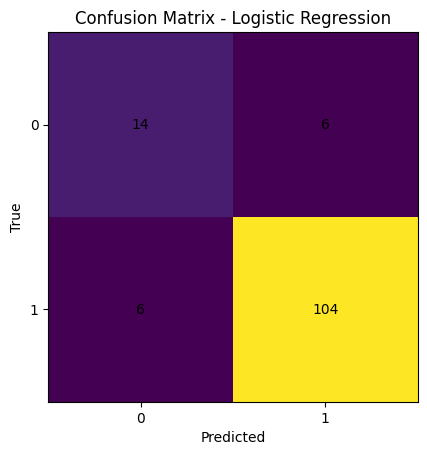

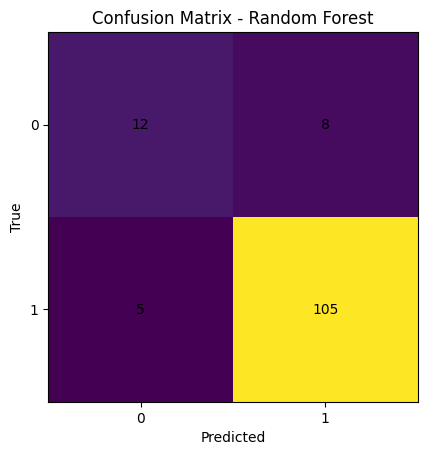

In [ ]:
# Confusion Matrix plots (no seaborn, single-plot rule, no explicit colors)
def plot_confusion(ax, cm, title):
    ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    # Annotate counts
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center')

fig1 = plt.figure()
cm_lr = confusion_matrix(y_test, y_pred_lr)
ax1 = fig1.gca()
plot_confusion(ax1, cm_lr, "Confusion Matrix - Logistic Regression")
plt.show()

fig2 = plt.figure()
cm_rf = confusion_matrix(y_test, y_pred_rf)
ax2 = fig2.gca()
plot_confusion(ax2, cm_rf, "Confusion Matrix - Random Forest")
plt.show()

## ROC Curves (optional, shown only if probabilities available)

<Figure size 640x480 with 0 Axes>

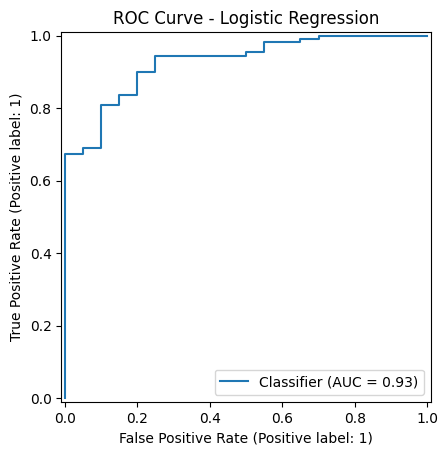

<Figure size 640x480 with 0 Axes>

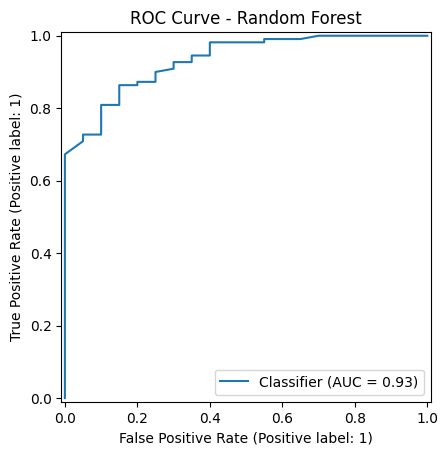

In [ ]:
if y_prob_lr is not None:
    fig = plt.figure()
    RocCurveDisplay.from_predictions(y_test, y_prob_lr)
    plt.title("ROC Curve - Logistic Regression")
    plt.show()

if y_prob_rf is not None:
    fig = plt.figure()
    RocCurveDisplay.from_predictions(y_test, y_prob_rf)
    plt.title("ROC Curve - Random Forest")
    plt.show()

## Feature Importances (Random Forest)
We plot the top 15 most important encoded features (post one-hot encoding).

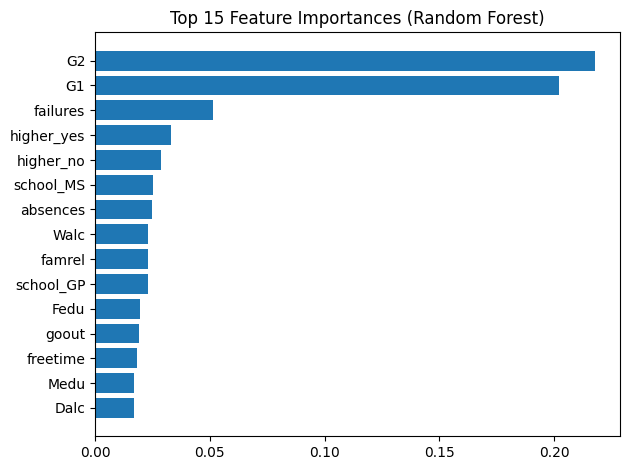

,feature,importance
14,G2,0.217823
13,G1,0.202248
5,failures,0.051183
53,higher_yes,0.033174
52,higher_no,0.028605
16,school_MS,0.025347
12,absences,0.024784
10,Walc,0.023104
6,famrel,0.022983
15,school_GP,0.022837


In [ ]:
# Extract and plot feature importances from RF
# Need to get the feature names after the ColumnTransformer
def get_feature_names(column_transformer, numeric_cols, categorical_cols):
    feature_names = []
    # Numeric passthrough/impute only
    feature_names.extend(numeric_cols)
    # OneHotEncoder feature names
    for name, trans, cols in column_transformer.transformers_:
        if name == 'cat':
            ohe = trans.named_steps['onehot']
            ohe_features = ohe.get_feature_names_out(categorical_cols)
            feature_names.extend(ohe_features.tolist())
    return feature_names

rf_clf = rf_model.named_steps['clf']
ct = rf_model.named_steps['preprocess']
feature_names = get_feature_names(ct, num_cols, cat_cols)
importances = rf_clf.feature_importances_

# Some columns may be dropped if missing; align lengths carefully
if len(importances) != len(feature_names):
    # Fallback: create simple range names if mismatch
    feature_names = [f"f{i}" for i in range(len(importances))]

imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(15)

# Bar plot (single figure, no explicit colors)
fig = plt.figure()
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

imp_df

In [ ]:
# 7) Save artifacts
out_dir = Path('artifacts')
out_dir.mkdir(exist_ok=True)

results_path = out_dir / 'results.csv'
results_df.to_csv(results_path, index=False)

print(f"Saved metrics to: {results_path.resolve()}")

Saved metrics to: /content/artifacts/results.csv
